In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_plotter.two_d import *
import seaborn as sns
# from tqdm import

In [2]:
# connectivity_min, connectivity_max = 0.1,130
connectivity_min, connectivity_max = 0,130
# random_input_span = (9.5,9.5)
random_input_span = (9.5,13.5)
# random_input_span = (1.2,2.8)

total_time = 100
delay = 0.06
alpha = 100

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'
# version = '_current_from_zero'
# version = '_v1.0'
version = '_v2.0'
# version = '_cluster_computed'

# Load related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_networks_name = target_networks_name + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

delay_folder_name = 'd_{}'.format(delay)
alpha_folder_name = 'alpha_{}'.format(alpha)

target_path

'Rotational_ensembles\\N10000_T100_I9.5_13.5_v2.0'

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
mean_periods_arr_dict = {}
field_average_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    g_d_path = os.path.join(target_path, g_folder, delay_folder_name, alpha_folder_name)
    
    try:
        g_ensembles_list = list_folders_in_path(g_d_path)
        g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
        
        if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
        
        sigma_glossary_dict[g] = []
        mean_periods_arr_dict[g] = []
        amin_saman_param_glossary_dict[g] = []
        field_average_glossary_dict[g] = []
        
    except: #if the given connectivity and delay has not been measured even once
        continue
    
    for ensemble_num in g_ensembles_list:
        ensemble_path = os.path.join(g_d_path, ensemble_num)
        with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
            sigma = float( file.readline() )
            sigma_glossary_dict[g].append( sigma )
        with open( os.path.join(ensemble_path,'field_average.txt') ) as file:
            field_avg = float( file.readline() )
            field_average_glossary_dict[g].append( field_avg )
        
#         if neuron_model == 'Rotational' or neuron_model == 'Non_repulsive_rotational' : #if not does not exist
        if neuron_model == 'Rotational' or neuron_model == 'Non_repulsive_rotational': #if not does not exist
            with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                amin_saman_param = float( file.readline() )        
                amin_saman_param_glossary_dict[g].append( amin_saman_param )        
        
        mean_periods_arr_dict[g].append( np.loadtxt(os.path.join(ensemble_path,'mean_spiking_periods.txt')) )
        


In [7]:
target_path

'Rotational_ensembles\\N10000_T100_I9.5_13.5_v2.0'

### Set theme of next plots

In [8]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [9]:
g_list = list(sigma_glossary_dict.keys())
g_list.sort()
g_arr = np.array(g_list)

In [10]:
def compute_ro():
    if random_input_span[1] != random_input_span[0]:
        ro = 1 / ( 2*np.pi*(random_input_span[1] - random_input_span[0]) )
    if random_input_span[1] == random_input_span[0]:
        ro = 1 / ( 2*np.pi )
    return ro

# Silent neurons

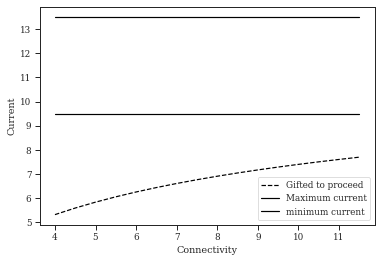

In [11]:
fig = plt.figure()
ax = fig.subplots()

ro = compute_ro()

ax.set_xlabel('Connectivity')
ax.set_ylabel('Current')

a_sterix = random_input_span[1] + 1/(ro*g_arr)
a_sterix -= np.sqrt( 2*random_input_span[1]/(ro*g_arr) + (ro*g_arr)**(-2) )
ax.plot(g_arr,a_sterix, label = 'Gifted to proceed', color='black', linestyle = '--')

max_current = random_input_span[1]*np.ones(len(g_arr))
min_current = random_input_span[0]*np.ones(len(g_arr))
ax.plot(g_arr, max_current, label = 'Maximum current',  color='black')
ax.plot(g_arr, min_current, label = 'minimum current',  color='black')

ax.fill_between(g_arr, min_current, a_sterix, where=(a_sterix > min_current), color='black',hatch="/", alpha=0.3)
# ax.fill_between(g_arr, min_current, max_current, color='C1', alpha=0.3)

plt.legend()

fig.savefig(os.path.join(target_path,'silent_neurons_asterix_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

In [12]:
silent_neurons_uniform_dist = num_neurons*(a_sterix - random_input_span[0])/(random_input_span[1] - random_input_span[0])
silent_neurons_uniform_dist[silent_neurons_uniform_dist<0] = 0

In [13]:
def silent_neurons_num(pops_list):
    silent_num = np.zeros(len(pops_list))
    for i,pop in enumerate(pops_list):
        nan_num = np.count_nonzero(np.isnan(pop))
#         nan_num = 0 if nan_num != 0 else nan_num
        silent_num[i] = nan_num
    return np.mean(silent_num)

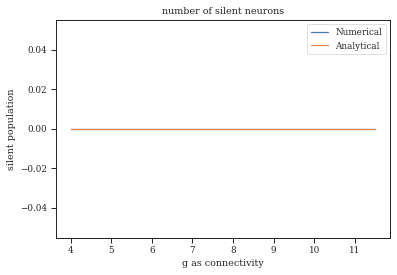

In [14]:
fig = plt.figure()
ax = fig.subplots()

silent_neurons = []

for g in g_list:
    silent_neurons.append( silent_neurons_num(mean_periods_arr_dict[g]) )

ax.plot(g_list,silent_neurons, label = 'Numerical')
ax.plot(g_list,silent_neurons_uniform_dist, label = 'Analytical')
plt.legend()

ax.set_title('number of silent neurons')
ax.set_ylabel('silent population')
ax.set_xlabel('g as connectivity')
fig.savefig(os.path.join(target_path,'silent_neurons_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

# Average of field intensity

In [15]:
e_mean = [ np.mean(field_average_glossary_dict[g]) for g in g_list ]
e_err = [ np.var(field_average_glossary_dict[g])**(0.5) for g in g_list ]

In [16]:
x = g_list
y = e_mean

sample_length = int( len(x)/3 )

x_log = np.log10(x)[-sample_length:]
y_log = np.log10(y)[-sample_length:]

trend_curve = x**(np.polyfit(x_log,y_log,1)[0]) * 10**(np.polyfit(x_log,y_log,1)[1])
slope, shift = np.polyfit(x_log,y_log,1)

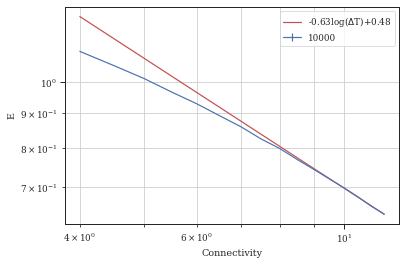

In [17]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

ax.errorbar(x = g_list, y = e_mean, yerr = e_err, label = str(num_neurons))
# ax.errorbar(x = g_list, y = e_mean, yerr = sigma_mean, label = str(num_neurons))
ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_xlabel('Connectivity')
ax.set_ylabel('E')

# ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')

fig.savefig(os.path.join(target_path,'field_average_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

## Field regression

### When not all the neurons are gifted to spike:
if one neuron has an input current smaller than a value $ a_{*} $ its potential will not reach the threshold

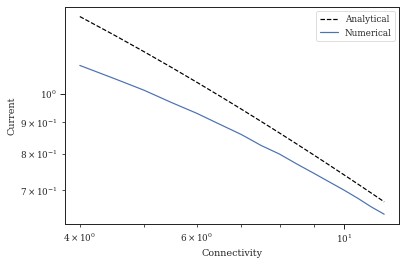

In [18]:
ro = compute_ro()
g_arr = np.array(g_list)
e_analytical_asterix = random_input_span[1] / g_arr + 1/(ro * g_arr**2)
e_analytical_asterix -= np.sqrt( (ro**(-2) * g_arr**(-4)) + 2*random_input_span[1] / (ro*g_arr**3) ) #minus answer

fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

first_indexes = 0
ax.plot(g_arr[first_indexes:], e_analytical_asterix[first_indexes:], color='black', linestyle = '--', label = 'Analytical')
ax.plot(g_arr[first_indexes:], e_mean[first_indexes:], label = 'Numerical')

plt.legend()
ax.set_xlabel('Connectivity')
ax.set_ylabel('Current')

fig.savefig(os.path.join(target_path,'field_zeroth_order_asterix_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

### If all the neurons are gifted to spike
if all the neurons have relatively a large input current

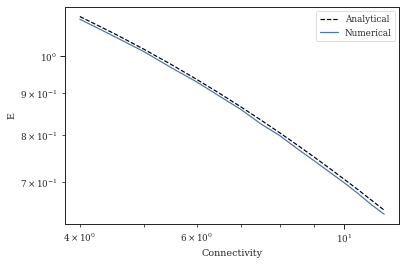

In [19]:
ro = compute_ro()
g_arr = np.array(g_list)
e_analytical = ro*(random_input_span[1]**2 - random_input_span[0]**2)
e_analytical /=  (1 + g_arr*ro*(random_input_span[1] - random_input_span[0]))*2

fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

first_indexes = 0
ax.plot(g_arr[first_indexes:], e_analytical[first_indexes:],  color='black', linestyle = '--', label = 'Analytical')
ax.plot(g_arr[first_indexes:], e_mean[first_indexes:], label = 'Numerical')

plt.legend()
ax.set_xlabel('Connectivity')
ax.set_ylabel('E')

fig.savefig(os.path.join(target_path,'field_zeroth_order_simple_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

### A flexible model for Regression process
the connectivity g will determine the number of gifted to spike neurons. So lets fit with the help of the two perior models

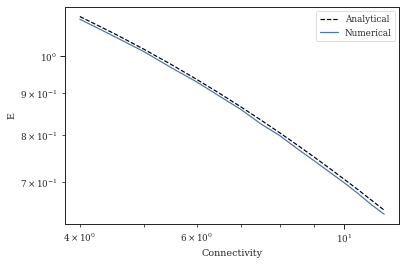

In [20]:
ro = compute_ro()


off_region_mask = a_sterix > random_input_span[0]

e_analytical[off_region_mask] = e_analytical_asterix[off_region_mask]

fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

first_indexes = 0
ax.plot(g_arr[first_indexes:], e_analytical[first_indexes:],color='black', linestyle = '--', label = 'Analytical')
ax.plot(g_arr[first_indexes:], e_mean[first_indexes:], label = 'Numerical')

plt.legend()
ax.set_xlabel('Connectivity')
ax.set_ylabel('E')

fig.savefig(os.path.join(target_path,'field_zeroth_order_developed_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

## Standard deviation of the field

In [21]:
sigma_mean = [ np.mean(sigma_glossary_dict[g]) for g in g_list ]
sigma_err = [ np.var(sigma_glossary_dict[g])**(0.5) for g in g_list ]

In [22]:
x = g_list
y = sigma_mean

sample_length = int( len(x)/3 )
x_log = np.log10(x)[-sample_length:]
y_log = np.log10(y)[-sample_length:]

trend_curve = x**(np.polyfit(x_log,y_log,1)[0]) * 10**(np.polyfit(x_log,y_log,1)[1])
slope, shift = np.polyfit(x_log,y_log,1)

In [23]:
len(x)

16

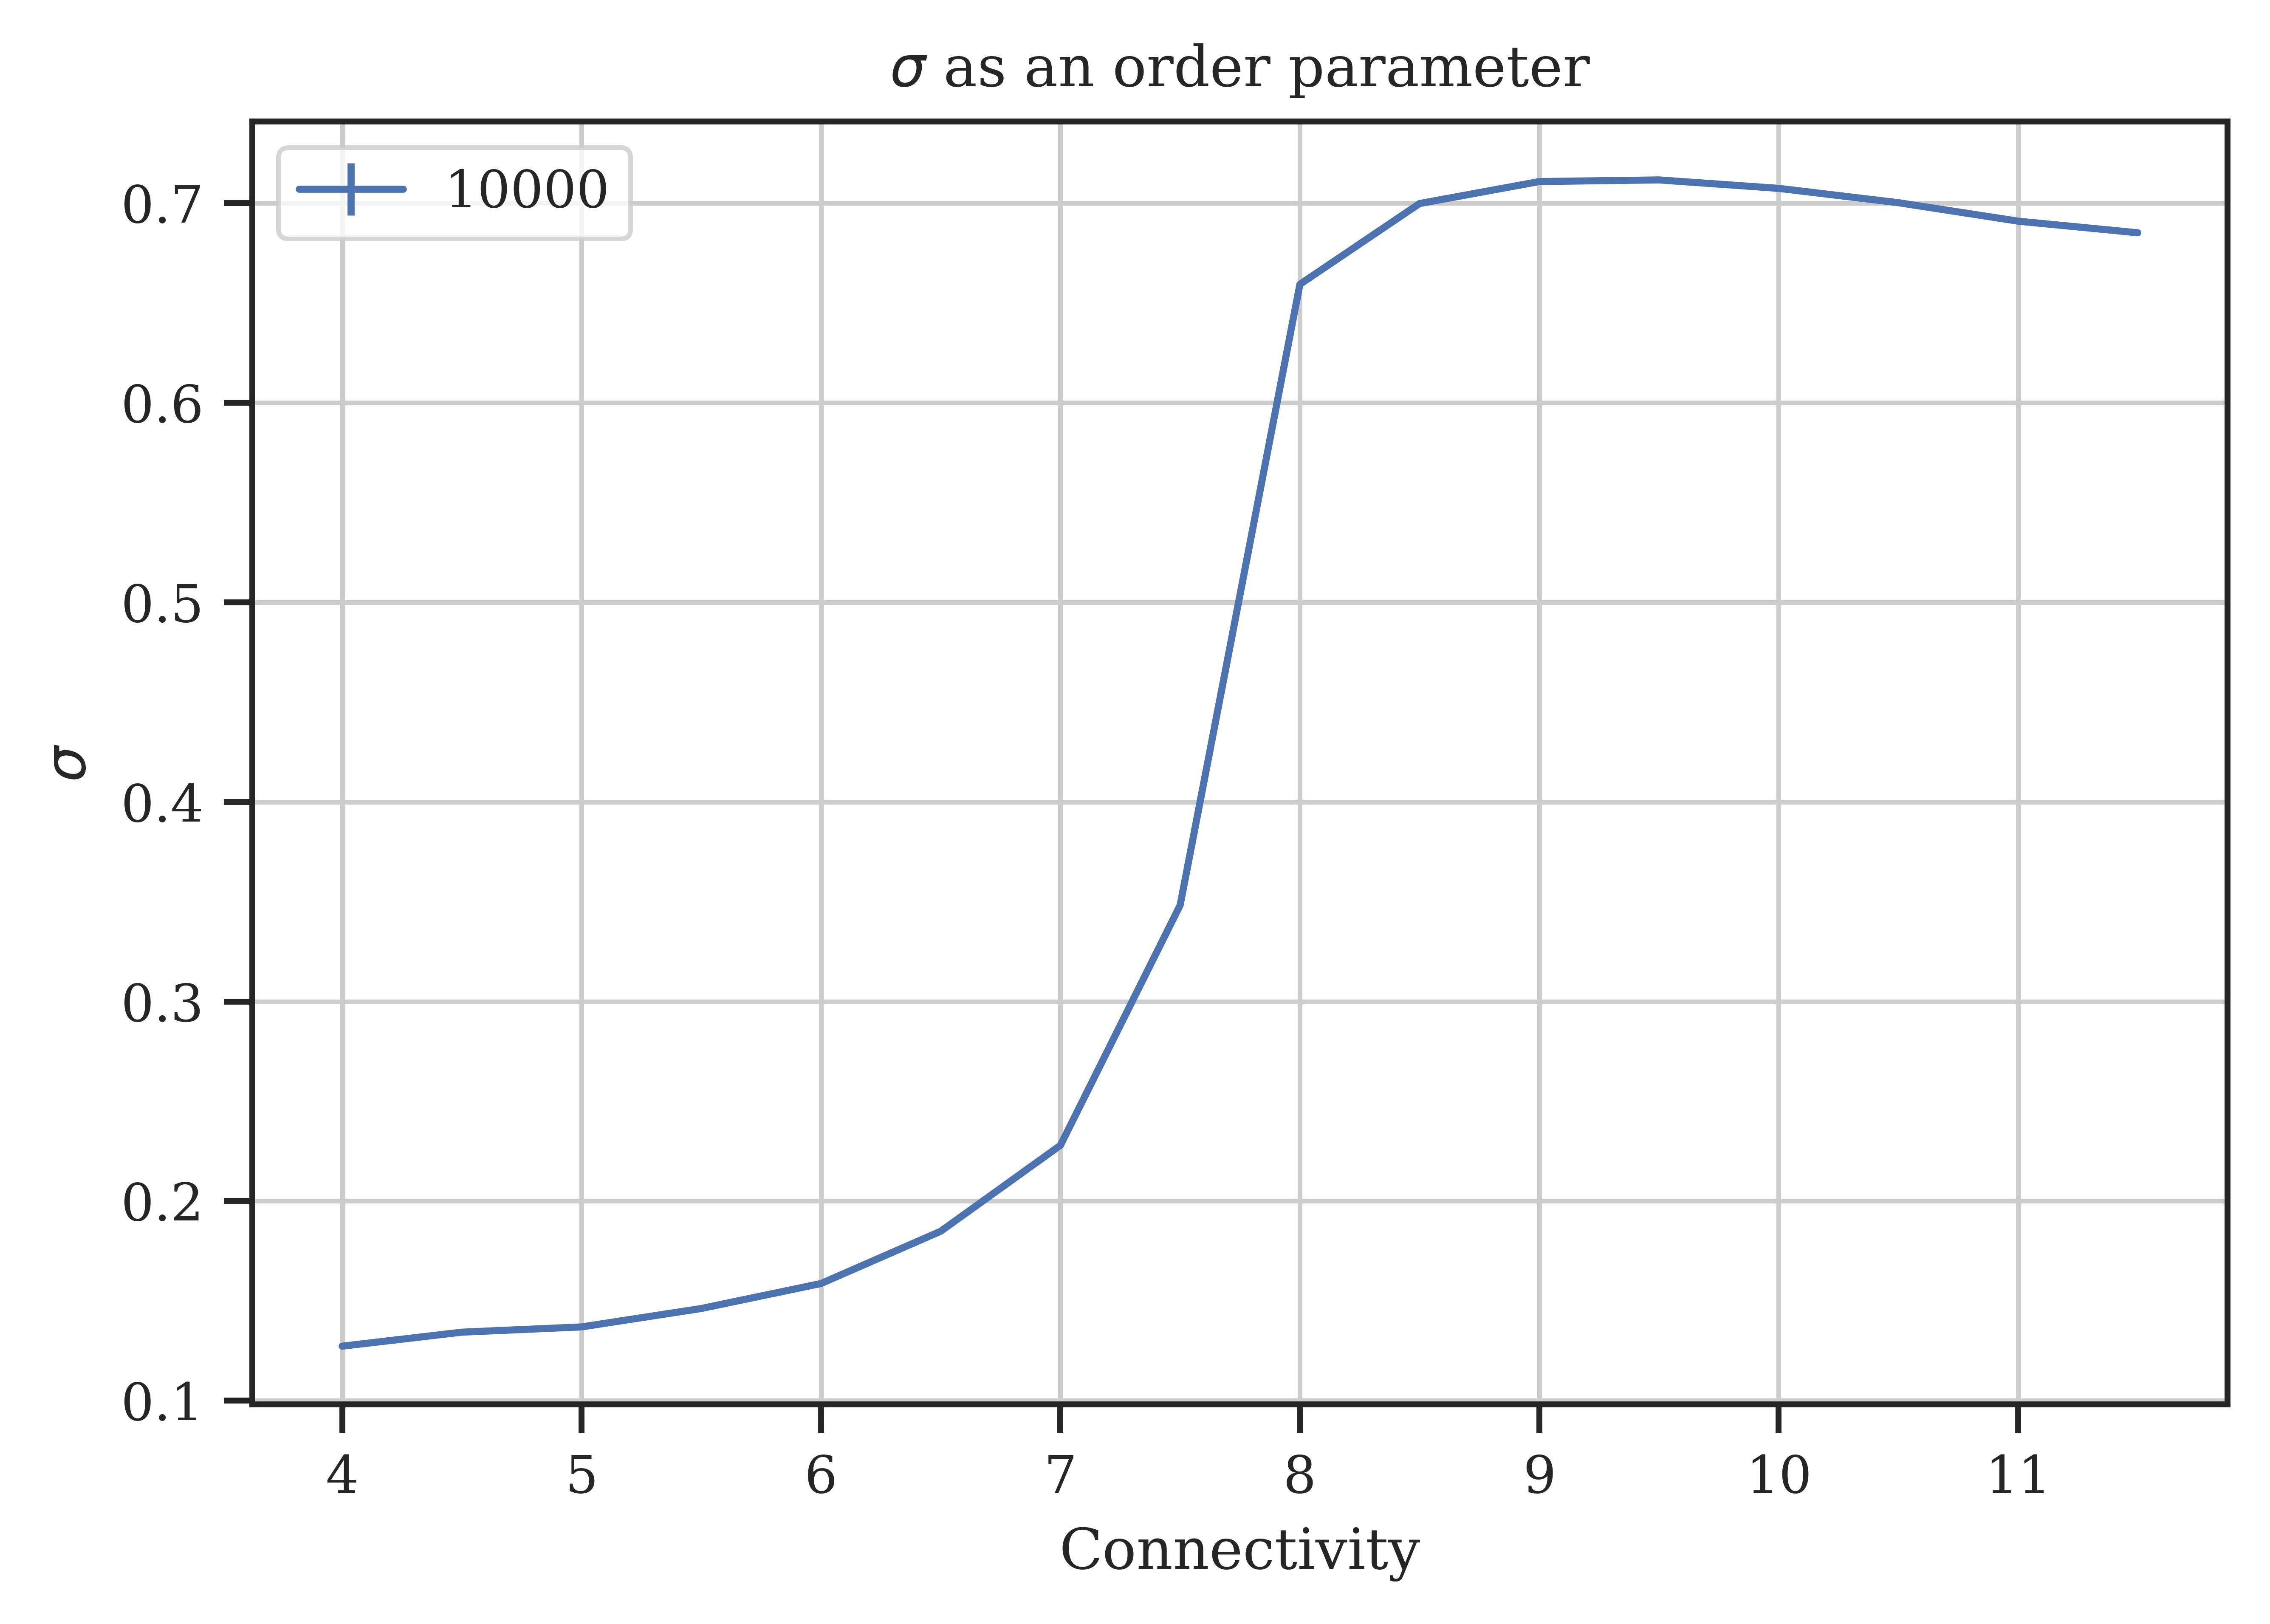

In [24]:
fig = plt.figure(dpi = 1000)
ax = fig.subplots()

# ax.set_xscale("log")
# ax.set_yscale("log")

ax.errorbar(x = g_list, y = sigma_mean, yerr = sigma_err, label = str(num_neurons))
# ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_title('$\sigma$ as an order parameter')
ax.set_xlabel('Connectivity')
ax.set_ylabel('$\sigma$')

# ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')


fig.savefig(os.path.join(target_path,'sigma_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

### the current deviation (gE)

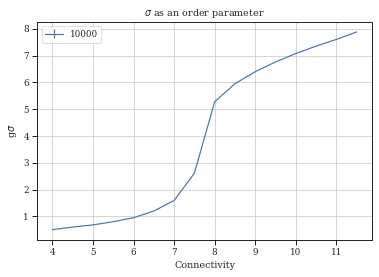

In [25]:
fig = plt.figure()
ax = fig.subplots()

# ax.set_xscale("log")
# ax.set_yscale("log")

ax.errorbar(x = g_arr, y = sigma_mean*g_arr, yerr = sigma_err, label = str(num_neurons))
# ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_title('$\sigma$ as an order parameter')
ax.set_xlabel('Connectivity')
ax.set_ylabel('g$\sigma$')

# ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')


fig.savefig(os.path.join(target_path,'gsigma_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

# Relative deviation

In [26]:
x = g_list
y = np.array( sigma_mean ) / np.array( e_mean )

sample_length = int( len(x)/20 )
x_log = np.log10(x)[-sample_length:]
y_log = np.log10(y)[-sample_length:]

trend_curve = x**(np.polyfit(x_log,y_log,1)[0]) * 10**(np.polyfit(x_log,y_log,1)[1])
slope, shift = np.polyfit(x_log,y_log,1)

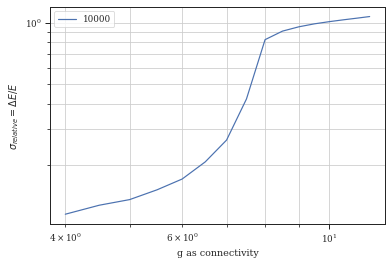

In [27]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

# ax.errorbar(x = g_list, y = e_mean, yerr = sigma_mean, label = str(num_neurons))
ax.plot(g_list, y, label = str(num_neurons))
# ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_xlabel('g as connectivity')
ax.set_ylabel('$\sigma_{relative} = \Delta E / E $')

# ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')

fig.savefig(os.path.join(target_path,'relative_dev_field_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

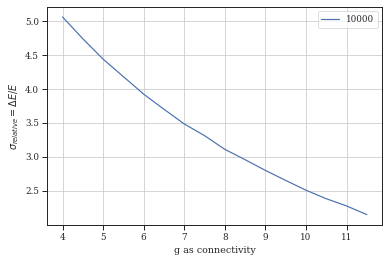

In [28]:
fig = plt.figure()
ax = fig.subplots()

# ax.set_xscale("log")
# ax.set_yscale("log")

# ax.errorbar(x = g_list, y = e_mean, yerr = sigma_mean, label = str(num_neurons))
ax.plot(g_list, random_input_span[0] - g_arr*e_mean, label = str(num_neurons))
# ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_xlabel('g as connectivity')
ax.set_ylabel('$\sigma_{relative} = \Delta E / E $')

# ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')

# fig.savefig(os.path.join(target_path,'relative_dev_field_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

## Amin Saman parameter

In [29]:
amin_saman_param_mean = [ np.mean(amin_saman_param_glossary_dict[g]) for g in g_list ]
amin_saman_param_err = [ np.var(amin_saman_param_glossary_dict[g])**(0.5) for g in g_list ]

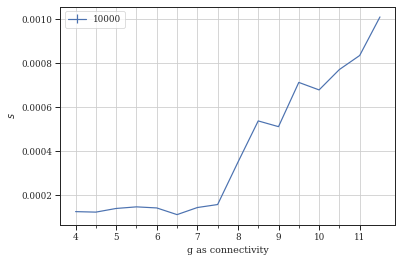

In [30]:
if neuron_model == 'Rotational' or neuron_model == 'Non_repulsive_rotational': #if not does not exist
    fig = plt.figure()
    ax = fig.subplots()
    ax.errorbar(x = g_list, y = amin_saman_param_mean, yerr = amin_saman_param_err, label = str(num_neurons))

    plt.legend()
    # ax.set_title('$\sigma$')
    ax.set_xlabel('g as connectivity')
    ax.set_ylabel('$s$')
    
    ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

    ax.grid(which='both')
    fig.savefig(os.path.join(target_path,'amin_saman_param_g_{}_{}.png'.format(connectivity_min, connectivity_max) ) )

## Mean spikies period

In [31]:
def mean_heights_hist(pops_list,given_bins):
    heights_reservoir = np.zeros((len(pops_list),len(given_bins)-1))
    for i,pop in enumerate(pops_list):
        heights = np.histogram(pop, bins = given_bins, density = True)[0]
        heights_reservoir[i] = heights
    return np.mean(heights_reservoir,axis = 0)

In [32]:
# bins = np.arange(0,100,0.5)
bins = np.logspace(np.log10(0.1),np.log10(1000.0), 100)
mean_heights_dict = {}
for g in g_list:
    mean_heights_dict[g] = mean_heights_hist(mean_periods_arr_dict[g],bins)

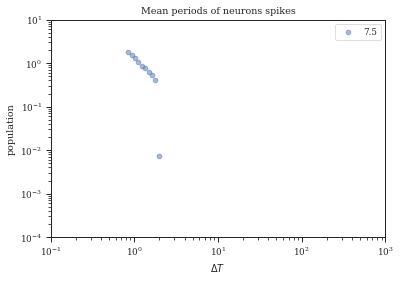

In [33]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")


desired_g_list = g_list[7:30:10]
# desired_g_list = [1.8,19.5]

for g in desired_g_list:
    non_zero_mask = (mean_heights_dict[g] != 0 ) & (bins[:-1] != 0)
    ax.scatter(bins[:-1][non_zero_mask],mean_heights_dict[g][non_zero_mask],label = round(g,2), alpha = 0.5)
plt.legend()
plt.xlim(0.1, bins[-1])
# plt.ylim(10**-4, num_neurons)
# plt.ylim(10**-4, 10**2)
plt.ylim(num_neurons**-1, 10)
# plt.xscale('log')
# plt.yscale('log')


ax.set_title('Mean periods of neurons spikes')
ax.set_ylabel('population')
ax.set_xlabel('$\Delta T$')
fig.savefig(os.path.join(target_path,'mean_spiking_persiods_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

## Trending line in histogram

In [34]:
desired_g = 0.9

In [35]:
non_zero_mask = (mean_heights_dict[desired_g] != 0 ) & (bins[:-1] != 0)
x = bins[:-1][non_zero_mask]
y = mean_heights_dict[desired_g][non_zero_mask]

x_log = np.log10(x)[5:15]
y_log = np.log10(y)[5:15]

trend_curve = x**(np.polyfit(x_log,y_log,1)[0]) * 10**(np.polyfit(x_log,y_log,1)[1])
slope, shift = np.polyfit(x_log,y_log,1)

KeyError: 0.9

In [ ]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(x,y,label = 'g = {}'.format( round(desired_g,2) ), alpha = 0.8)

ax.set_xlim(0.1, bins[-1])
ax.set_ylim(num_neurons**-1,10) #we are working with densities

ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_title('Trending line of mean periods of neurons spikes')
ax.set_ylabel('population')
ax.set_xlabel('$\Delta T$')
fig.savefig(os.path.join(target_path,'mean_spiking_persiods_with_trending_line_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

### Mean spike of seprate neurons

In [ ]:
desired_g = 1

In [ ]:
fig = plt.figure()
ax = fig.subplots()

# ax.set_xscale("log")
# ax.set_yscale("log")

ideal_couples = np.stack((g_arr,e_mean)).T[27:31]

for g,e in ideal_couples:
    ax.plot( np.linspace(*random_input_span, num=num_neurons)- g*e,
            np.flip(np.sort(mean_periods_arr_dict[g][0])),
           label = g)
    
plt.legend()